# Проверка гипотез по увеличению выручки в интернет-магазине. Оценить результаты A/B теста.

**Цель исследования:**

- Приоритизировать гипотезы, после выбрать самую перспективную;
- Запустите A/B-тест и проанализируйте результаты.


**Ход исследования:**

1. Загрузка данных и подготовка их к анализу
2. Приоритизация гипотез
3. Анализ A/B-теста
    1. Расчет кумулятивных показателей
    2. Анализ выбросов
    3. Проверка статистических гипотез
4. Общий вывод

##  Загрузка данных и подготовка их к анализу

In [1]:
# Импортируем библиотеки
import pandas as pd
from scipy import stats as st
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Откроем файлы с данными
try:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv'))
except:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv'))

Ознакомимся с таблицей **hypothesis**

In [3]:
pd.options.display.max_colwidth = 120
display(hypothesis)
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Таблица **hypothesis**:

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
____

Ознакомимся с таблицей **orders**

In [4]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Таблица **orders**:

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

___

Ознакомимся с таблицей **visitors**

In [5]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Таблица **visitors**:

- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста
____

Подготовим данные, сделаем следующее:
- Приведем названия столбцов всех таблиц к нижнему регистру;
- Проверим таблицы на пропуски и дубликаты;
- Пронумеруем гипотезы, добавив столбец с индексом;
- Заменим тип данных в  столбцах *data*;
- Проверим не попадают ли пользователи в обе группы.

In [6]:
# Приведём название столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
visitors.columns = visitors.columns.str.lower()

In [7]:
# Проверим на пропуски
print(hypothesis.isna().sum())
print('-------------------------------------')
print(orders.isna().sum())
print('-------------------------------------')
print(visitors.isna().sum())

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
-------------------------------------
transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64
-------------------------------------
date        0
group       0
visitors    0
dtype: int64


In [8]:
# Проверим на дубликаты
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


In [9]:
# Присвоим столбец с номером гипотезы
hypothesis = hypothesis.reset_index()

In [10]:
# Заменим тип данных
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

Так же необхоимо проверить, не попадаются ли пользователи в обе тестовые группы.

In [11]:
print('Уникальных пользователей, сделавших заказ:', orders['visitorid'].nunique())

Уникальных пользователей, сделавших заказ: 1031


In [12]:
# Выведим таблицу с общим количеством идентификаторов заказов, уникальные идентификаторы пользователя 
# и дней тестирования по группам
stat_group = orders.groupby('group').agg({'transactionid':'count', 'visitorid':'nunique', 'date':'nunique'})
stat_group

,transactionid,visitorid,date
group,,,
A,557,503,31
B,640,586,31


In [13]:
print('Всего заказов по двум группам:',stat_group['visitorid'].sum())

Всего заказов по двум группам: 1089


Получили подтверждение того, что пользоватли попали сразу в две тестовые группы, т.к. количество уникальных пользователей отличается от суммы заказов по группам.

In [14]:
# Проверю, сколько пользователей, попали в две группы
erroneous_dt= orders.groupby('visitorid').agg({'group':'nunique'}).query('group > 1').index
print('Заказов пользователей попало в две группы:', len(erroneous_dt))
erroneous_dt

Заказов пользователей попало в две группы: 58


Int64Index([   8300375,  199603092,  232979603,  237748145,  276558944,
             351125977,  393266494,  457167155,  471551937,  477780734,
             818047933,  963407295, 1230306981, 1294878855, 1316129916,
            1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
            1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
            2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
            2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
            2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
            3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
            3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
            3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
            4186807279, 4256040402, 4266935830],
           dtype='int64', name='visitorid')

Удалим данные 58 пользователей попавших в обе группы, что бы результаты исследования не исказились.

In [15]:
# Удалим данные из таблицы orders
orders = orders.query('visitorid not in @erroneous_dt')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [16]:
# Проверим, что получилось
stat_group2 = orders.groupby('group').agg({'transactionid':'count', 'visitorid':'nunique', 'date':'nunique'})
stat_group2

,transactionid,visitorid,date
group,,,
A,468,445,31
B,548,528,31


**Вывод**

- Ознакомились с таблицами **hypothesis**, **orders**, **visitors**;
- Предобработали данные для исследования.

____

## Приоритизация гипотез

Расчитаем фреймворк ICE по формуле: 
    
- **ICE = (Impact x Confidence) / Efforts**

Отсортируем по убыванию приоритета.

,index,hypothesis,ice
8,8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


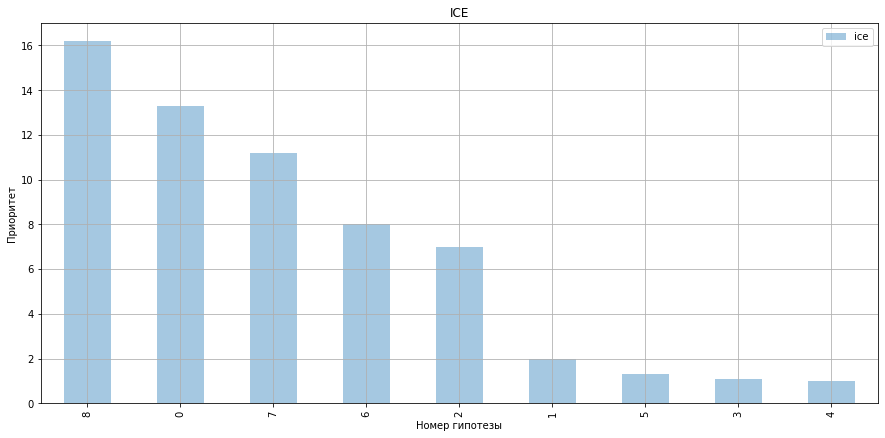

In [17]:
# Рассчитаем ICE
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(1)

# Выведем таблицу с гипотезами на экран и отсортируем по убыванию ICE
ice = hypothesis[['index','hypothesis','ice']].sort_values(by='ice', ascending=False)
display(ice)

ice.plot(x='index', y='ice', kind='bar',grid=True, alpha=0.4, figsize = (15,7))
plt.title('ICE')
plt.xlabel('Номер гипотезы')
plt.ylabel('Приоритет')
plt.show()

Расчитаем фреймворк RICE по формуле :

- **RICE = (Reach x Impact x Confidence) / Efforts**

Отсортирую по убыванию приоритета.

,index,hypothesis,rice
7,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


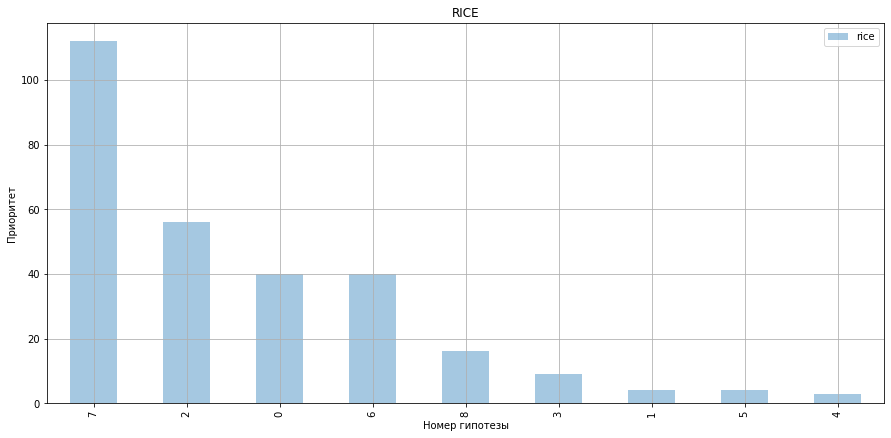

In [18]:
# Рассчитаем RICE
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

# Выведем таблицу с гипотезами на экран и отсортируем по убыванию RICE
rice = hypothesis[['index','hypothesis','rice']].sort_values(by='rice', ascending=False)
display(rice)

rice.plot(x='index', y='rice', kind='bar',grid=True, alpha=0.4, figsize = (15,7))
plt.title('RICE')
plt.xlabel('Номер гипотезы')
plt.ylabel('Приоритет')
plt.show()

**Вывод**

После применения методов ICE и RICE по показателям видно, что в первой пятерке выявили одинаковые гипотезы под номером: 
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- №2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- №6 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- №8 Запустить акцию, дающую скидку на товар в день рождения. 

Применив метод RICE, мы видим, что увеличился показатель гипотез:

- №2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Т.к. в данном методе добавляется параметр Reach показывающий скольких пользователей затронет изменение, которое хотим внести. Так же в первой тройке осталась гипотеза под номером 0, удержала позицию за счет высокого показателя Impact, равному 10.
____

## Анализ A/B-теста
### Расчет кумулятивных показателей
#### Построить график кумулятивной выручки по группам

In [19]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [20]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date': 'max',
        'group': 'max',
        'transactionid': 'nunique',
        'visitorid': 'nunique',
        'revenue': 'sum'}),
    axis=1,).sort_values(by=['date', 'group'])

ordersAggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 55 to 930
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           62 non-null     datetime64[ns]
 1   group          62 non-null     object        
 2   transactionid  62 non-null     int64         
 3   visitorid      62 non-null     int64         
 4   revenue        62 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.9+ KB


In [21]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date': 'max', 
         'group': 'max', 
         'visitors': 'sum'}),
    axis=1,).sort_values(by=['date', 'group'])

visitorsAggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 55 to 930
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ KB


In [22]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.to_string())

         date group  orders  buyers  revenue  visitors
0  2019-08-01     A      23      19   142779       719
1  2019-08-01     B      17      17    59758       713
2  2019-08-02     A      42      36   234381      1338
3  2019-08-02     B      40      39   221801      1294
4  2019-08-03     A      66      60   346854      1845
5  2019-08-03     B      54      53   288850      1803
6  2019-08-04     A      77      71   388030      2562
7  2019-08-04     B      68      66   385740      2573
8  2019-08-05     A      99      92   474413      3318
9  2019-08-05     B      89      87   475648      3280
10 2019-08-06     A     114     104   515332      3985
11 2019-08-06     B     112     109   690490      3935
12 2019-08-07     A     130     120   638580      4629
13 2019-08-07     B     135     132   909654      4644
14 2019-08-08     A     144     133   727219      5239
15 2019-08-08     B     157     154  1059795      5298
16 2019-08-09     A     155     143   861456      5856
17 2019-08

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и В
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

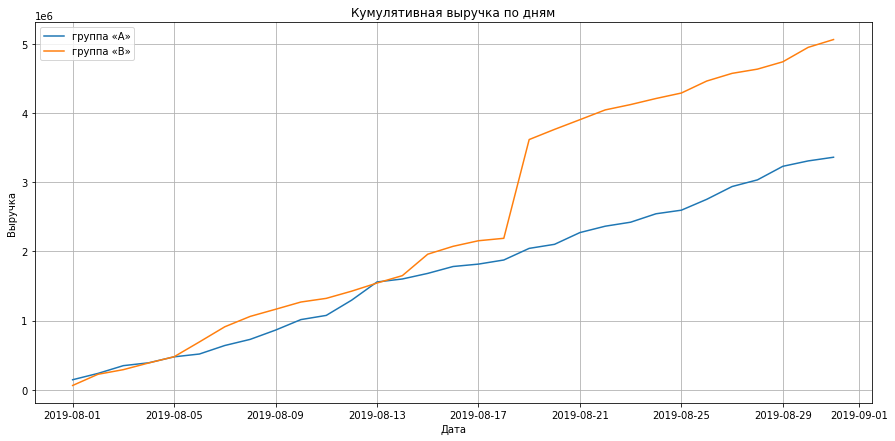

In [24]:
# задаём сетку отрисовки графика
plt.figure(figsize=(15, 7))

# Строим график выручки группы А и группы В
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='группа «А»')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='группа «В»')

plt.title('Кумулятивная выручка по дням')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.legend()
plt.show()

**Вывод**

Во время проведения теста (31 день) выручка групп «А» и «В» равномерно увеличивается. 

Так же видно резкий скачок в выручке группы «В» 19 числа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

___


#### Построить график кумулятивного среднего чека по группам

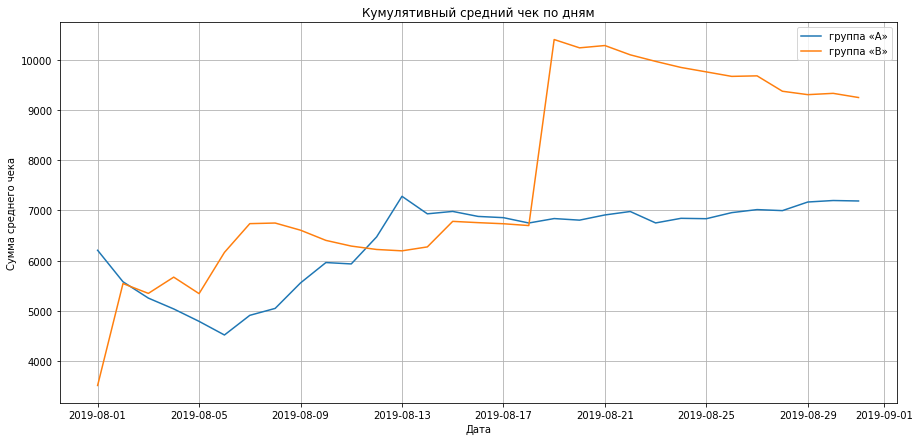

In [25]:
# задаём сетку отрисовки графика
plt.figure(figsize=(15, 7))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='группа «А»')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа «В»')

plt.title('Кумулятивный средний чек по дням')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.grid(True)
plt.legend()
plt.show()

**Вывод**

Кумулятивное значение среднего чека колеблется до 19 дня тестового периода исследования, после показатель среднего чека стабилизировался.

Так же средний чек группы  «А» медленно растет, а в группе «В»  после резкого скачка значение постепенно снижается.
Принимать решения по этой метрике рано, возможно выбросы искажают результаты.
____

#### Построить график относительного изменения кумулятивного среднего чека группы «В» к группе «А»

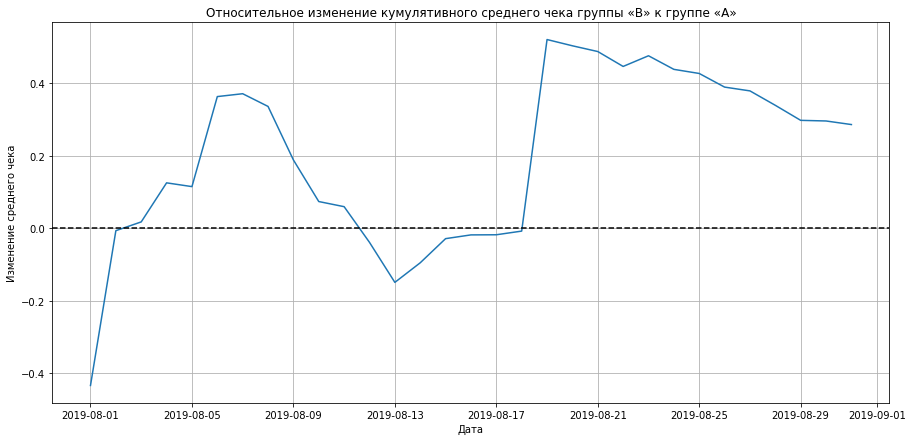

In [26]:
# задаём сетку отрисовки графика
plt.figure(figsize=(15, 7))

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
        (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека группы «В» к группе «А»')
plt.xlabel('Дата')
plt.ylabel('Изменение среднего чека')
plt.grid(True)
plt.show()

**Вывод**

В нескольких точках график различия между сегментами резко колеблется в определённых числах. 
___

#### Построить график кумулятивного среднего количества заказов по группам

In [27]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

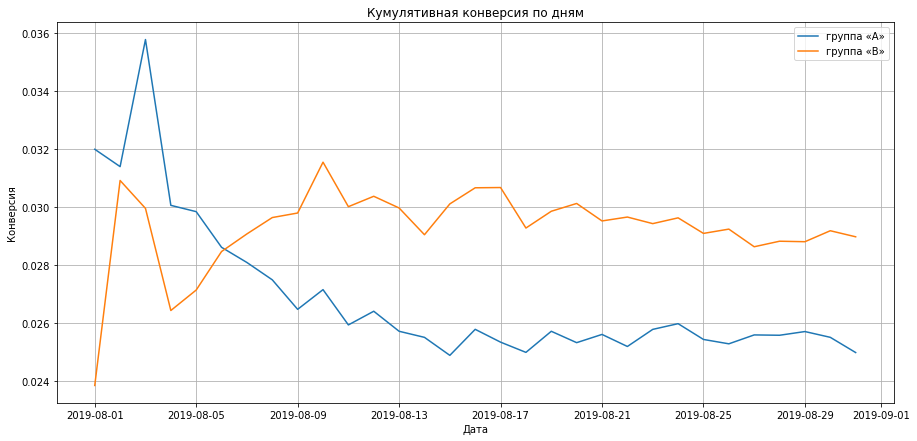

In [28]:
# задаём сетку отрисовки графика
plt.figure(figsize=(15, 7))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='группа «А»')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='группа «В»')

plt.title('Кумулятивная конверсия по дням')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.grid(True)
plt.legend()
plt.show()

**Вывод**

Конверсия нестабильна с первого дня тестирования.

На седьмой день тестового периода конверсия группы «В» стала намного выше, чем у группы «А».

___

#### Построить график относительного различия конверсии группы «В» к группе «А»

In [29]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
                              cumulativeDataB[['date','conversion']],left_on='date', 
                                                                     right_on='date',
                                                                     how='left', 
                                                                     suffixes=['A', 'B'])
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


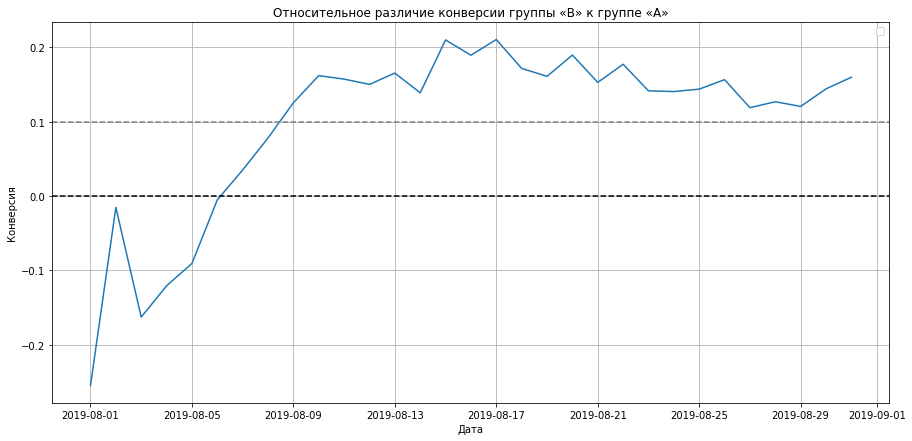

In [30]:
# задаём сетку отрисовки графика
plt.figure(figsize=(15, 7))

# Построим график относительного различия кумулятивных конверсий:
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

plt.title('Относительное различие конверсии группы «В» к группе «А»')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.grid(True)
plt.legend()
plt.show()

**Вывод**

Почти с самого начала группа «В» лидирует. По конверсии виден стабильный показатель в 10% относительно группы «А».
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.
___

### Поиск выбросов
#### Построить точечный график количества заказов по пользователям

In [31]:
ordersByUsers = (orders.groupby('visitorid', as_index=False)
                       .agg({'transactionid': 'nunique'}))

ordersByUsers.columns = ['userid', 'orders']

# Построю таблицу, группирую по id заказа
ordersByUsers.sort_values(by='orders', ascending=False).head(5)

,userid,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Есть пользователи совершившие 11, 9 и 8 заказов за месяц.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


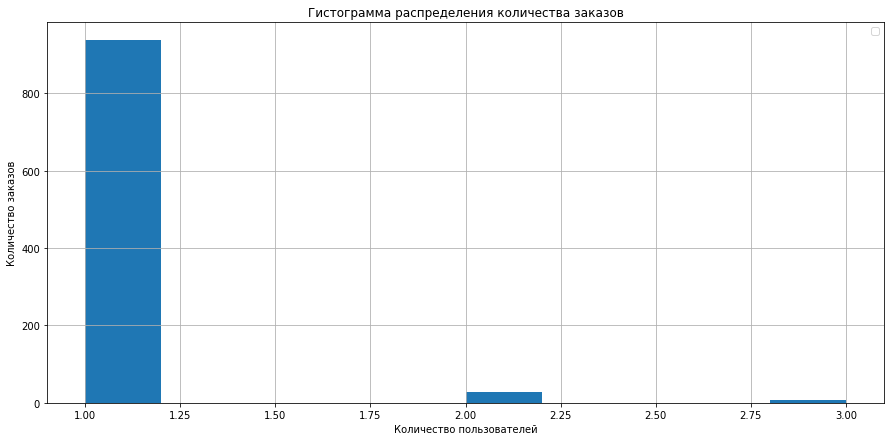

In [32]:
# задаём сетку отрисовки графика
plt.figure(figsize=(15, 7))

# Построю гистограмму распределения количества заказов на одного пользователя
plt.hist(ordersByUsers['orders']) 
plt.title('Гистограмма распределения количества заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend()
plt.show()

Покупатели чаще всего делают только один заказ за месяц, так же доля тех, кто делает 2-4 заказа в месяц - значительна.
Оценим количество заказов ещё одним способом.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


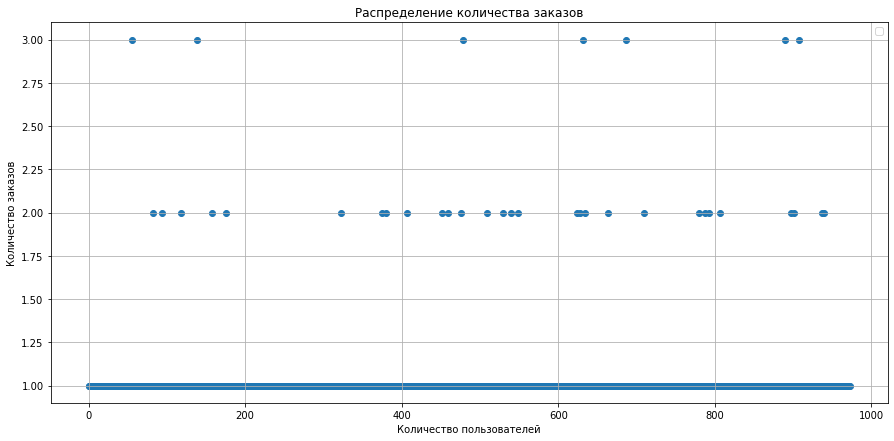

In [33]:
# задаём сетку отрисовки графиков
plt.figure(figsize=(15, 7))

# Построю точечный график
x_values = pd.Series(range(0,len(orders['visitorid'].unique())))
plt.scatter(x_values, ordersByUsers['orders'])

plt.title('Распределение количества заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend()
plt.show()

На графике видно, много покупателей совершают больше одной покупки за месяц. Ответим на этот вопрос точно посчитав выборочные перцентили.
___

In [34]:
# Посчитаю 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

**Вывод**

Не более 5% покупателей делают больше 2 заказов месяц и не более 1% больше 4 заказов в месяц.
Буду считать аномальным значением - от трёх и больше заказа в месяц.
___

#### Построить точечный график стоимостей заказов

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


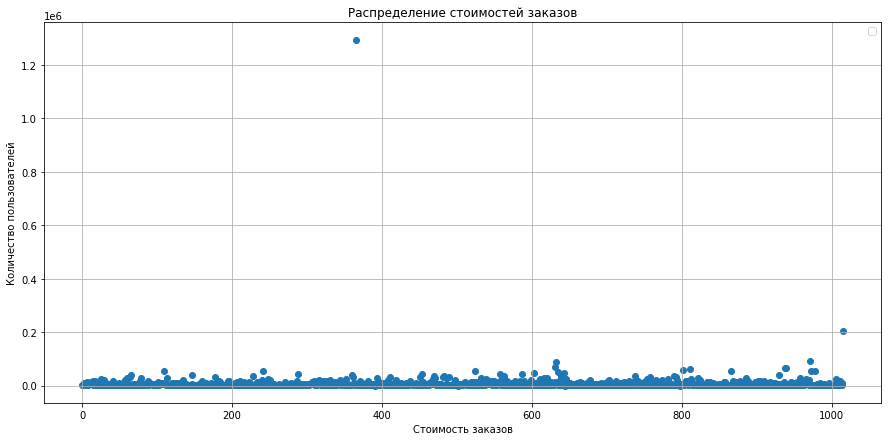

In [35]:
# задаём сетку отрисовки графиков
plt.figure(figsize=(15, 7))

x_values = pd.Series(range(0,len(orders['revenue'])))

# Построю точечный график распределения количества заказов на одного пользователя
plt.scatter(x_values, orders['revenue']) 
plt.title('Распределение стоимостей заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.show()

На графике видно 2 аномальных значения. Увеличу график, что бы подробнее рассмотреть распределение заказов.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


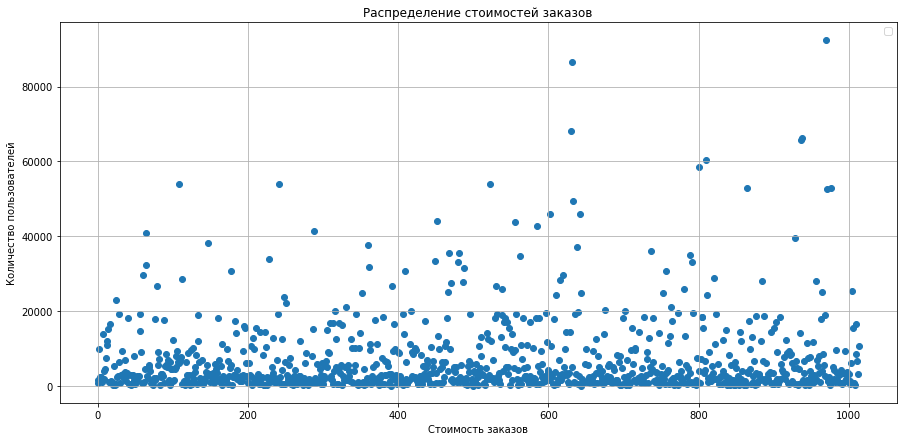

In [36]:
# задаём сетку отрисовки графиков
plt.figure(figsize=(15, 7))

x_values = pd.Series(range(0,len(orders.query('revenue <=150000')['revenue'])))

plt.scatter(x_values, orders.query('revenue <=150000')['revenue']) 
plt.title('Распределение стоимостей заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.show()

Основная масса заказов суммой до 10 000, а вот заказы более чем 30 000 встречаются реже. Ответим на этот вопрос точно посчитав выборочные перцентили.

In [37]:
# Посчитаю 95-й и 99-й перцентили стоимости заказов
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

**Вывод**

Не более 5% покупателей делают заказ больше чем на 28 000 месяц и не более 1% тратят 58 000 на заказ в месяц.
Будем считать аномальным значением заказы суммой больше 28 000.
___

### Проверка статистических гипотез
#### Посчитать статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным

In [38]:
# Ежедневное количество посещений в группе «А» 
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Выведем таблицу с посещениеми пользователей по дням в группе «А» 
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
    .agg({'date': 'max', 
          'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [39]:
# Ежедневное количество посещений в группе «В»
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Выведем таблицу с посещениеми пользователей по дням в группе «В»
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
    .agg({'date': 'max', 
          'visitorsPerDateB': 'sum'}),axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [40]:
# Ежедневное количество заказов и сумма заказов в группе «А» 
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': 'nunique', 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# Сумма заказов и выручки в группе «А»
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'ordersPerDateA': 'sum', 
         'revenuePerDateA': 'sum'}),axis=1,).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


In [41]:
# Ежедневное количество заказов и сумма заказов в группе «В» 
ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
               .groupby('date', as_index=False)
               .agg({'transactionid': 'nunique', 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# Сумма заказов и выручки в группе «В» 
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 
         'ordersPerDateB': 'sum', 
         'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [42]:
# Объединим данные в одну таблицу
data = (ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
                    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
                    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
                    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
                    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
                    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
                    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

In [43]:
print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [44]:
# Посчитаем статистическую значимость различия в среднем количестве заказов между группами 
# для пользователей, которые сделали хотябы один заказ, укажем число совершённых заказов
ordersByUsersA = (orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))
ordersByUsersA.columns = ['userid', 'orders']

ordersByUsersB = (orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))
ordersByUsersB.columns = ['userid', 'orders'] 

ordersByUsersA.head()

,userid,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [45]:
# Зададим переменные в которых пользователям из разных групп будет соответствовать количество заказов 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(
          0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
          name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(
          0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
          name='orders')],axis=0) 

Сформулируем нулевую(H₀) и альтернативную(На) гипотезы для «сырых» данных:
- H₀ - Статистически значимых различий конверсии между группами нет;

- На - Статистически значимые различия конверсии между группами есть.

In [46]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие конверсии:', '{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительное различие конверсии: 0.160


**Вывод**

P-value меньше 0.05, значит, существует различия в конверсии по сырым данных между группами, поэтому нулевую гипотезу отвергаем.

Прирост конверсии группы «В», относительно группы «А» составляет 16%.
___

#### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем нулевую(H₀) и альтернативную(На) гипотезы для «сырых» данных:
- H₀ - Статистически значимых различий в среднем чеке между группами нет;

- На - Статистически значимые различия в среднем чеке между группами есть.

In [47]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

print('Относительное различие среднего чека:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
Относительное различие среднего чека: 0.287


**Вывод**

P-value 0.829 больше 0.05, значит, что статистически значимых различий в среднем чеке между группами нет, нулевую гипотезу не отвергаем.

Относительная разница среднего чека группы «В» на 29% Выше, чем в группе «А». 

Скорее всего такая разница вызвана аномальными значениями, отчистим данные для дальнейшего анализа.
___

#### Посчитать статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным

In [48]:
# Узнаем, сколько всего аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userid'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] >= 28000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Всего аномальных пользователей:',abnormalUsers.shape[0])

Всего аномальных пользователей: 55


In [49]:
# Задам переменные, в которых будут очищенные данные по количеству заказов  пользователей из разных групп теста
sampleAFiltered = pd.concat(
            [ordersByUsersA[np.logical_not(ordersByUsersA['userid'].isin(abnormalUsers))]['orders'],
                  pd.Series(
            0, index=np.arange(cumulativeDataA['visitors'].sum() - len(ordersByUsersA['orders'])),name='orders')], axis=0)

sampleBFiltered = pd.concat(
            [ordersByUsersB[np.logical_not(ordersByUsersB['userid'].isin(abnormalUsers))]['orders'],
                  pd.Series(
            0, index=np.arange(cumulativeDataB['visitors'].sum() - len(ordersByUsersB['orders'])),name='orders')], axis=0)

Сформулируем нулевую(H₀) и альтернативную(На) гипотезы для «очищенных» данных:

- H₀ - Статистически значимых различий конверсии между группами нет;

- На - Статистически значимые различия конверсии между группами есть.

In [50]:
print('p-value:''{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие конверсии:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value:0.008
Относительное различие конверсии: 0.194


**Вывод**

P-value меньше 0.05,анализ очищенных данных показывает, что существует различия в конверсии по очищенным данным между группами, поэтому нулевую гипотезу отвергаем.

Прирост конверсии группы «В», относительно группы «А» теперь составляет 19%.
____

#### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем нулевую(H₀) и альтернативную(На) гипотезы для «очищенных» данных:
- H₀ - Статистически значимых различий в среднем чеке между группами нет;

- На - Статистически значимые различия в среднем чеке между группами есть.

In [51]:
print('p-value:', '{0:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
            np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print('Относительное различие среднего чека:', '{0:.3f}'.format(orders[np.logical_and(orders['group'] == 'B',
            np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/orders[
            np.logical_and(orders['group'] == 'A',
            np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()- 1))

p-value: 0.762
Относительное различие среднего чека: -0.022


**Вывод**

После удаления выбросов статистически значимых различий в среднем чеке между группами всё так же нет, нулевую гипотеу не отвергаем.

Теперь относительный проигрыш группы «В» равен 2%.
____

### Общий вывод

1. В ходе исследования загрузили данные таблиц  **hypothesis**, **orders**, **visitors** и подготовили их к анализу.

1. При приоритизации гипотез использовали по фреймворкам ICE и RICE, выявили самые перспективные, стоит проверить их в следующем порядке:


    1. №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (RICE=112)
    2. №2 Добавить блоки рекомендаций товаров на сайт инт. магазина, чтобы повысить конверсию и средний чек заказа (RICE=56)
    3. №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (RICE=40)

3. При проведении А/В- теста построили графики кумулятивной выручки, среднего чека, конверсии по группам, а затем посчитали статистическую значимость различий конверсий и средних чеков по сырым и очищенным данным.

В ходе теста было выявлено:

- Значимое различие конверсии между группами. Прирост конверсии группы «В», относительно группы «А» теперь составляет 19% на очищенных от выбросов данных. 

- Различие в сумме среднего чека незначительная, относительный проигрыш группы «В» равен 2%  

Предлагаю остановить тест и зафиксировать победу группы «В», т.к. и до и после отчистки данных от аномальных значений показатели конверсии по этой группе выше, чем у группы «А».

___